In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas_profiling import ProfileReport
import json
import pickle
import requests
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
EPC = pd.read_csv('../data/raw/EPC_data_1516575_homes.csv') # loading the dataframe
if 'Unnamed: 0' in EPC.columns:
    EPC.drop('Unnamed: 0', inplace=True, axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (24,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
lat_long = pd.read_csv('../data/raw/osopenuprn_202205.csv')

In [4]:
EPC_lat_long = pd.merge(EPC, lat_long, left_on="uprn", right_on="UPRN", how="left")

In [5]:
# performing the pandas profiling on the data
EPC_profile = ProfileReport(EPC_lat_long, title="EPC Profile Report {0} Homes".format(len(EPC_lat_long)), explorative=True)


In [6]:
profile = EPC_profile.description_set # grabbing descriptive set

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:61: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""


PicklingError: Could not pickle the task to send it to the workers.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:61: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/missingno/missingno.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.get_xticklabels(), rotati

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

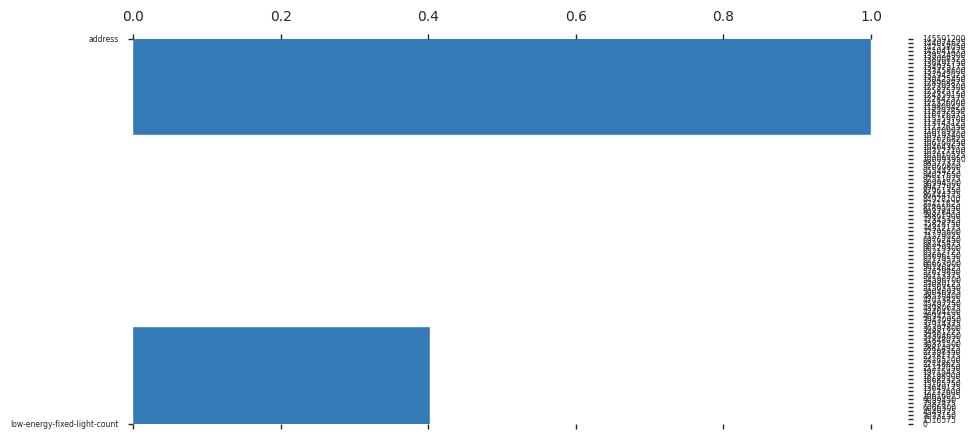

In [8]:
# saving results to html
EPC_profile.to_file('pandas_profiling_{0}_homes.html'.format(len(EPC_lat_long)))

In [ ]:
profile['table']
profile['correlations']['phi_k']['current-energy-efficiency'].sort_values(ascending=False)

In [ ]:
profile['variables']['current-energy-efficiency']

In [10]:
def grouping_connected_buildings(df, min_units=4):
    '''Groups the dataframes by address to analyze large buildings as a group.
        INPUTS:
        df (pandas df): dataframe of EPC data for a particular postcode
        min_units (int): minimum number of units within a building for it to be considered large enough for analysis.
        
        RETURNS:
        dwellings (pandas df): dataframe containing grouped buildings.'''
    # grouping by address2 which is the building number
    group = df.groupby('address2')
    units = group.size().to_frame(name='units')
    dwellings = (units.join(group.agg({'current-energy-efficiency': 'mean'}).rename(columns={'current-energy-efficiency': 'mean'}))
       .join(group.agg({'current-energy-efficiency': 'std'}).rename(columns={'current-energy-efficiency': 'std'})).reset_index()
       )
    dwellings = dwellings[dwellings['units']>min_units].reset_index(drop=True)
    
    return dwellings

In [12]:
complexes = pd.DataFrame() # establishing a pandas dataframe that will contain all the complexes from each post code
for code in tqdm(EPC['postcode'].unique()):
    postcode = EPC[EPC['postcode']==code]
    dwellings = grouping_connected_buildings(postcode)
    complexes = pd.concat([complexes, dwellings], axis=0, ignore_index=True)
print(complexes['std'].mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82456/82456 [2:05:18<00:00, 10.97it/s]

9.351714314195469


In [13]:
EPC['current-energy-efficiency'].std()

14.118461260456625

In [14]:
cor, __ = pearsonr(complexes['mean'], complexes['std'])
cor

-0.7023184308777453

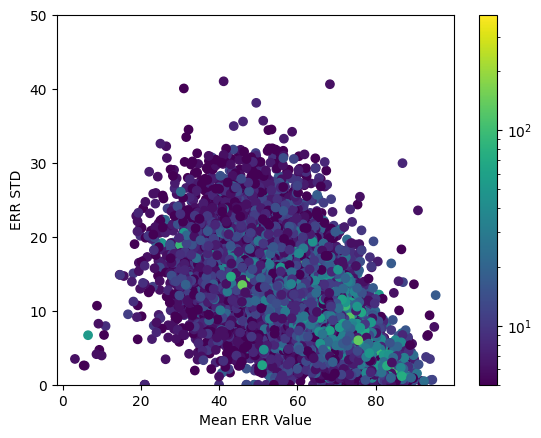

In [16]:
plt.scatter(complexes['mean'], complexes['std'], c=complexes['units'], norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('Mean ERR Value')
plt.ylabel('ERR STD')
plt.ylim([0,50])
plt.show()